<h1 style="font-size:40px;"><center>Exercise I:<br> Training of simple MLP models
</center></h1>


# Short summary
In this exercise you will: 

* train MLPs for simple classification and regression problems.
* learn how hyper-parameters such as learning rate, batch size and number of epochs affect training.

You should write the report of the exercise within this notebook. The details of how to do that can be found below in section "Writing the report".

**Deadline for submitting the report: See Canvas assignment.**

## The data
We will use two synthetic different data sets in this exercise

### syn2
The *syn2* dataset represents a binary classification problem. The input data is 2D which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. The dataset is generated using random numbers each time you run the cell. This means that each time you generate the data it will be slightly different. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot the *syn2* dataset.

### regr1
The *regr1* dataset represents a regression problem. It has one input and one target variable. It a cosinus function, with the possibility to add some noise and dampening on the output. Again see the cell "PlotData" to look at the dataset.

## The exercises
There are 8 questions in this exercise. These 8 questions can be found in three different cells below (see section "The Different Cells"). The first 6 questions will use the *regr1* dataset and questions 7-8 will use *syn2*.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | MLP | Needed | Defines the MLP model |
| 3 | Data | Needed | Defines the functions to generate the artificial datasets |
| 4 | PlotData | Information | Plots the 2D classification datasets |
| 5 | Statistics | Needed | Defines the functions that calculates various performance measures |
| 6 | Boundary | Needed | Function that can show 2D classification boundaries | 
| 7 | Ex1 | Exercise | For question 1-4 |
| 8 | Ex2 | Exercise | For question 5-6 |
| 9 | Ex3 | Exercise | For question 7-8 |

To start with the exercise you need to run all cells with the celltype "Needed". The very first time we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work your way down the cells. Later, when you have started to work with the notebook it may be easier to use the command "Run All" or "Run all above" found in the "Cell" dropdown menu.

## Writing the report
The report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction about the content and purpose of the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question! 

## Last but not least
Have fun!

---

### CellName: Init (#1)
### CellType: Needed
### Cell instruction: Initializing the libraries

In the cell below, we will import needed libraries. 

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
from jinja2.utils import markupsafe 
from markupsafe import Markup

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, regularizers, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import scipy as sp
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, log_loss, classification_report
import pandas as pd

2022-11-16 08:42:42.995368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### CellName: MLP (#2)
### CellType: Needed
### Cell instruction: Defining the MLP model

This cell defines the MLP model. There are a number of parameters that is needed to 
define a model. Here is a list of them: **Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.

* inp_dim: the input dimension (integer)

* n_nod: size of the network, eg [5] for a one hidden layer with 5 nodes and [5,3] for a two layer network with 5 and 3 hidden nodes each.

* act_fun: the activation function. Most common are
    * 'relu'
    * 'tanh'
        
* out_act_fun: the activation function for the output nodes. Most common are
    * 'linear'
    * 'sigmoid'
    * 'softmax'
    
* opt_method: The error minimization method. Common choices
    * 'SGD'
    * 'Adam'
    
* cost_fun: The error function used during training. There are three common ones
    * 'mean_squared_error'
    * 'binary_crossentropy'
    * 'categorical_crossentropy'

* lr_rate: The learning rate.

* metric: The metric to use besides the loss. Common values
    * accuracy
    * mse

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
def mlp(inp_dim,
            n_nod,
            act_fun = 'tanh',
            out_act_fun = 'linear',
            opt_method = 'SGD',
            cost_fun = 'mse',
            lr_rate = 0.01,
            metric = 'mse',
            num_out = None):
    
    lays = [inp_dim] + n_nod
    
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input')
    
    X = main_input
    for i, nod in enumerate(n_nod):
        X = Dense(nod, 
                  activation = act_fun)(X)
        
    output = Dense(1, activation = out_act_fun )(X)
    
    method = getattr(optimizers, opt_method)
    
    model =  Model(inputs=[main_input], outputs=[output])
    model.compile(optimizer = method(learning_rate = lr_rate),
                  loss = cost_fun,
                  metrics=[metric])       

    return model



### CellName: Data (#3)
### CellType: Needed
### Cell instruction: Defining synthetic data sets

This cell defines the two synthetic datasets. The last function is used for standardization of the data. 

Run the cell by entering into the cell and press "CTRL Enter".

In [3]:
def syn2(N):
    
    global seed
     
    x = np.empty(shape=(N,2), dtype = np.float32)  
    d = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)

    # Positive samples
    x[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))

    # Negative samples 
    x[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))
    
    # Target
    d[:N1] = np.ones(shape=(N1,))
    d[N1:] = np.zeros(shape=(N-N1,))

    return x,d


def regr1(N, len = 2, damp=0, v=0):

    global seed

    dx = 2*len*np.pi /(N-1)
    x = np.empty(N, dtype = np.float32) 
    for i in range(N):
        x[i] = i*dx
    
    noise =  lambda  n : np.random.normal(0,1,n)
    if damp == 1:
        d = np.cos(x)*np.exp(-x*0.05)
    else:
        d = np.cos(x)
    
    std_signal = np.std(d)
    d = d + v * std_signal * noise(N)
        
    return x, d


def standard(x):
    return np.mean(x, axis=0) , np.std(x, axis=0)
    

### CellName: PlotData (#4)
### CellType: Information
### Cell instruction: Plotting the data

Here we just generate 100 cases for *syn2* and the *regr1* dataset and plot them. 

Run the cell by entering into the cell and press "CTRL Enter". 

**Note!** This cell is not needed for the actual exercises, it is just to visualize the two datasets.

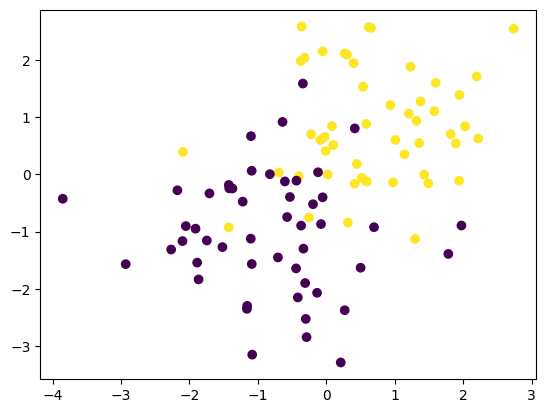

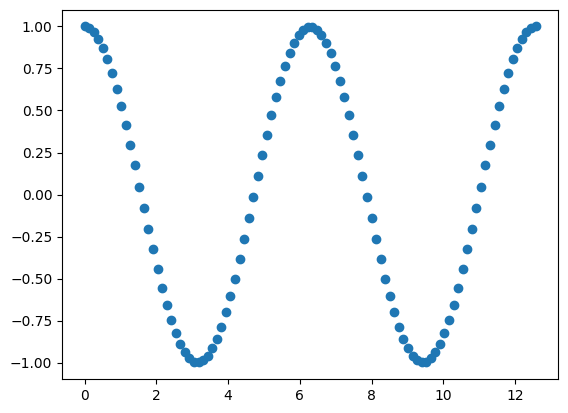

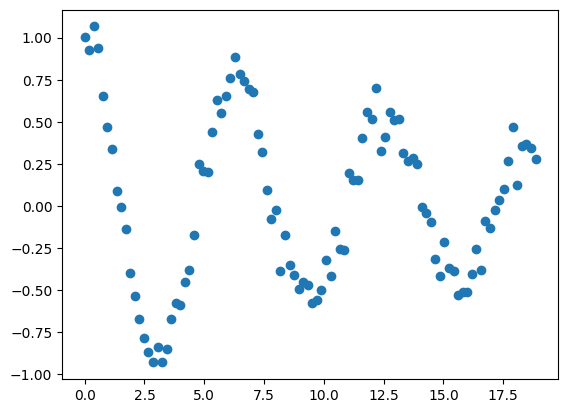

In [4]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

x,d = syn2(100)
plt.figure(1)
plt.scatter(x[:,0],x[:,1], c=d)

# Regression, one period, no noise
x,d = regr1(100, 2, 0, 0)
plt.figure(2)
plt.scatter(x,d)

# Regression, 1.5 period, exponential damping, some noise
x,d = regr1(100, 3, 1, 0.2)
plt.figure(3)
plt.scatter(x,d)


### CellName: Statistics (#5)
### CellType: Needed
### Cell instruction: Present result for both classification and regression problems

This cell defines two functions that we are going to call using a trained model to calculate both error and performance measures. 

Run the cell by entering into the cell and press "CTRL Enter".

In [5]:
def stats_class(x = None, y = None, label = 'Training', modl = None):
    """
    input :  
             x = input
             y = output
             label = "Provided text string"
             modl = the model
             
    output : 
             accuracy = fraction of correctly classified cases
             loss = typically the cross-entropy error
    """
    
    def binary(y1):
        y1[y1>.5] = 1.
        y1[y1<= .5] = 0.        
        return y1

    y_pr = modl.predict(x, batch_size = x.shape[0], verbose=0).reshape(y.shape)
                
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [y==1, y_pr[y==1.] > 0.5, y==0, y_pr[y==0.]<= 0.5]]
    
    acc = (tp + tn) / (len(y))
    loss = modl.evaluate(x, y , batch_size =  x.shape[0], verbose=0)
                
    A = ['Accuracy', 'CEE']
    B = [acc, loss[0]]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.4f}'.format(A[i], B[i]))

    return print('\n','#'*50)

def stats_reg(d = None, d_pred = None, label = 'Training', estimat = None):
    
    A = ['MSE']
    
    if label.lower() in ['training', 'trn', 'train']:
        mse = estimat.history['loss'][-1]
    else:
        mse = estimat.history['val_loss'][-1] 

    B = [mse]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.10f}'.format(A[i], B[i]))

    return print('\n','#'*50)


### CellName: Boundary (#6)
### CellType: Needed
### Cell Instruction: Decision boundary

This cell defines the function to plot the decision boundary for a 2D input binary MLP classifier. In short, this function defines a grid covering the input data. Each grid point is then used as an input to the trained MLP and to compute an output. If the output is close to 0.5 it is marked as the boundary. 

Run the cell by entering into the cell and press "CTRL Enter".

In [6]:
def decision_b(X, Y1, model ):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    Z[Z>.5] = 1
    Z[Z<= .5] = 0

    Y_pr = model.predict(X, batch_size = X.shape[0], verbose=0).reshape(Y1.shape)
  
    Y = np.copy(Y1)
    Y_pr[Y_pr>.5] = 1
    Y_pr[Y_pr<= .5] = 0
    Y[(Y!=Y_pr) & (Y==0)] = 2
    Y[(Y!=Y_pr) & (Y==1)] = 3
    
    
    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9) 
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker='+', c='k')
    plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], marker='o', c='k')
       
    plt.scatter(X[:, 0][Y==3], X[:, 1][Y==3], marker = '+', c='r')   
    plt.scatter(X[:, 0][Y==2], X[:, 1][Y==2], marker = 'o', c='r')
    
    
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()


---
End of "Needed" and "Information" cells. Below are the cells for the actual exercise.

---

### CellName: Ex1 (#7)
### CellType: Exercise
### Cell instruction: Instruction for questions 1-4
Questions 1-4 look at three essential parameters that controls the training process of an MLP: the *learning rate*, *batch size* and *number of epochs* (or epochs for short). By training process we mean here the minimization of the given loss function. The task is to train an MLP with four hidden nodes that can fit the *regr1* dataset. In this version of the dataset, there is no noise. Therefore, we need not specify any seed.

The dataset and network have been selected so that it is possible, but not trivial, to get a good training result.
A successful training means here when the networks has reached a loss < 0.01, and visually have fitted the data accurately. In this exercise we do not care about possible overfitting, only about the minimization of the loss function, we therefore do not have a validation dataset.

#### Question 1, variations in pre-defined MLP
For the first question you can simply run the cell below. It will load 50 samples from the *regr1* dataset (no noise added). The network has 4 hidden nodes in a single hidden layer, *tanh* activation function, linear output activation function, *stochastic gradient descent* as minimization method, MSE loss function, and a learning rate of 0.05.
It will train for 4000 epochs using a batchsize of 50, meaning that we efficiently are using ordinary gradient descent learning. Run this cell five times. **(a) Do you see the same loss vs epoch behavior each time your run?** If not, **why?** **(b) Do you observe that training fails, i.e. do not reach low loss, during any of these five runs?** 

#### Question 2, vary learning rate
You will now study what happens when you train with different learning rates. Test at least 5 different learning rates in the range from 0.001 to 0.5. For each learning rate train the network three times and record the average MSE value over these three runs. **Present your average MSE results and discuss your findings**.

**Note:** You should keep the same settings as for Q1, only vary the learning rate. The learning rate is best investigated with (roughly) proportional changes rather than constant steps: For example, trying 0.5, 0.2, 0.1, 0.05, 0.02 etc. typically gives more interesting results than 0.5, 0.4, 0.3, 0.2, 0.1.

#### Question 3, vary (mini)batch size
We now (hopefully) have discovered that the learning rate influences the efficiency of the loss minimization. We will now look at what happens when we use *stochastic gradient descent*, meaning that we will have a "batch size" that is smaller the the size of the training data. (We now adapt to Keras language, and use the word "batch" where most litterature would use "mini-batch".) Use a fixed learning rate of 0.05, but test different batch sizes in the range 1 to 50. Train three different networks for each batch size, but this time record if the training was successful (i.e. MSE < 0.01) and approximately after how many epochs the good solution was found. **Present and discuss your findings**.

**Note:** The batch size should (fairly well) divide the total data size. With a data size of 50, good batch sizes are 50, 25, 13, 10, 8, 7... Sizes that fit poorly, like 40, create a 'rest'-batch that must be handled by the Keras package somehow, and you need to carefully study Keras documentation to understand what it does.

#### Question 4, select good hyper-parameters
Find a combination of learning rate and batch size that gives a good solution within 1000 epochs. We always have to remember that two runs with identical hyper parameters (e.g. learning rate, batch size etc) will result in different final results. Your set of parameters should *most* of the times result in a good solution within 1000 epochs. **Present your best combination of learning rate and batch size, and its result**.


Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_78 (Dense)            (None, 4)                 8         
                                                                 
 dense_79 (Dense)            (None, 1)                 5         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


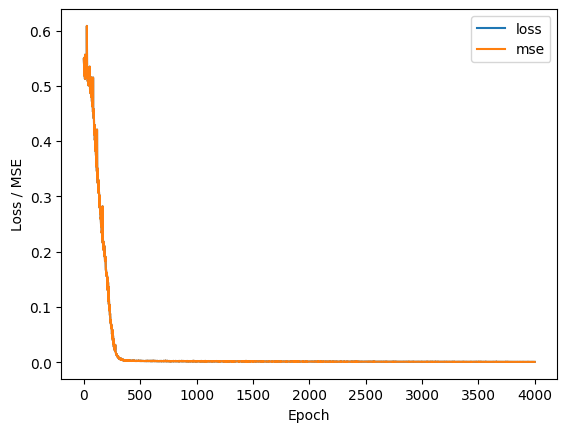

2/2 [==============================] - 0s 5ms/step

 ########## STATISTICS for Training Data ########## 

MSE             0.0007264598

 ##################################################
2/2 [==============================] - 0s 3ms/step


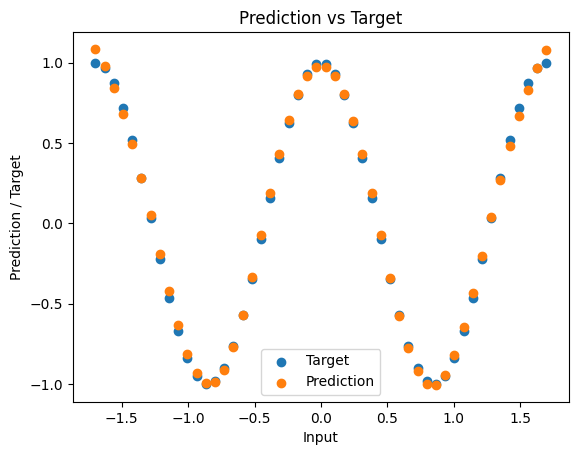

CPU times: user 34.2 s, sys: 3.85 s, total: 38.1 s
Wall time: 26.4 s


In [60]:
%%time
#### not used for Q1-Q4
# seed = 0 means random, seed > 0 means fixed
# seed = 0
# np.random.seed(seed) if seed else None
####

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

#### 
# Define the network, cost function and training settings
INPUT1 = {'inp_dim': 1,         
         'n_nod': [4],                   # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'SGD',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.1                 # learningrate
        }    
number_epochs = 4000
minibatch_size = 13
####    

# Get the model
model_ex1 = mlp(**INPUT1)

# Print a summary of the model
model_ex1.summary()

# Train the model
estimator_ex1 = model_ex1.fit(x_trn, d_trn,
                              epochs = number_epochs,      
                              batch_size = minibatch_size,
                              verbose = 0)


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex1.history.keys():
    plt.plot(estimator_ex1.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE
pred_trn = model_ex1.predict(x_trn).reshape(d_trn.shape)
stats_reg(d_trn, pred_trn, 'Training', estimator_ex1)

# Plot the result
d_pred = model_ex1.predict(x_trn)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()



#### CellName: Ex2 (#8)
### CellType: Exercise
### Cell instruction: Instruction for questions 5-6
The amount of weights in the network can also influence how long time we need to train, and of course if the problem itself is complex or not. The following two questions will highlight this.

#### Question 5, vary epochs
The example below will load a slightly more complex *regr1* problem (an additional quarter of a period). We will use 10 hidden nodes for this problem. Use your optimal set of learning rate and batch size as found in Q4 and train the network below. **Compare the number of epochs needed to reach a good solution with that of Q4**. Note, you may need to vary the number of epochs a lot! If you cannot find a good solution in a reasonable number of epochs, you can "revert" the problem: optimize learning rate and batch size for Q5, and the see how those hyper-parameters perform on Q4.

#### Question 6, vary network size and other hyper-parameters
Use the following line to load the *regr1* data set:

`x_trn, d_trn = regr1(75, 5, 1, 0.0)`

This will create an even more challenging regression task that may need an even larger network. Your task is to find a set of hyper-parameters (learning rate, batch size, epochs, 'size of the network') that result in a good solution. You can use more than one hidden layer for this task (if you want). To create many hidden layers, add many numbers to the n_nod list, for example: `'n_nod': [10,5,5]`. **Present your set of good hyper-parameters and the result**. 

**Note:** If you cannot solve this task in *reasonable* time, present your best attempt!


Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_76 (Dense)            (None, 10)                20        
                                                                 
 dense_77 (Dense)            (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


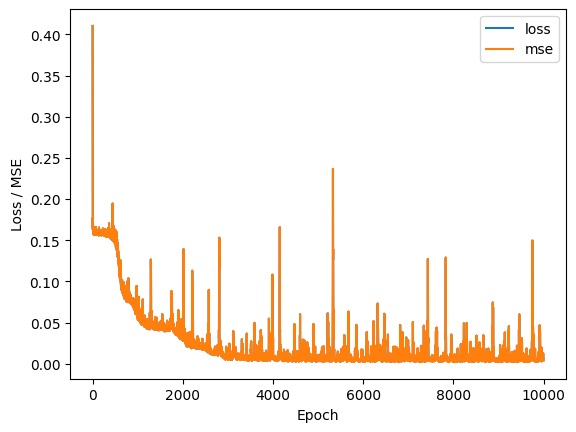

3/3 [==============================] - 0s 4ms/step

 ########## STATISTICS for Training Data ########## 

MSE             0.0041296543

 ##################################################
3/3 [==============================] - 0s 3ms/step


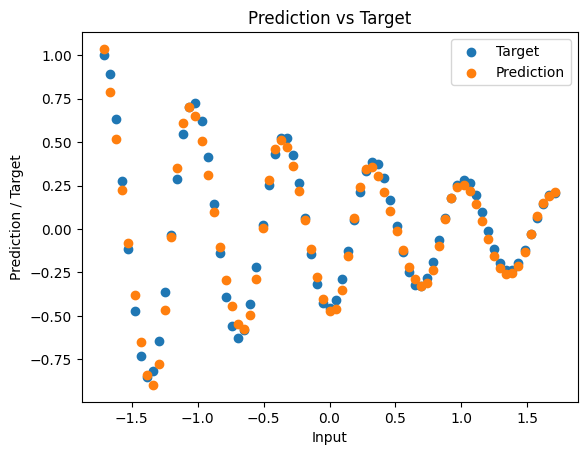

CPU times: user 1min 14s, sys: 8.77 s, total: 1min 23s
Wall time: 1min 8s


In [37]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# For Q5:
#x_trn, d_trn = regr1(50, 2.5, 0, 0.0)
# For Q6:
x_trn, d_trn = regr1(75, 5, 1, 0.0) #comment this line to reduce to simpler problem

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std


#### 
# Define the network, cost function and training settings
INPUT2 = {'inp_dim': 1,         
         'n_nod': [10],                  # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'Adam',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.05                 # learningrate
        }        
number_epochs = int(1e4)
minibatch_size = 25
####

# Get the model
model_ex2 = mlp(**INPUT2)

# Print a summary of the model
model_ex2.summary()

# Train the model
estimator_ex2 = model_ex2.fit(x_trn, d_trn,
                              epochs = number_epochs,      
                              batch_size = minibatch_size,
                              verbose = 0)


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex2.history.keys():
    plt.plot(estimator_ex2.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE and correlation coefficiant for the scatter plot
pred_trn = model_ex2.predict(x_trn).reshape(d_trn.shape)
stats_reg(d_trn, pred_trn, 'Training', estimator_ex2)

# Plot the result
d_pred = model_ex2.predict(x_trn)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()


### CellName: Ex3 (#9)
### CellType: Exercise
### Cell instruction: Instructions for questions 7-8
We will now look at the classification problem defined by the *syn1* dataset.
The cell below defines a single hidden node MLP. With this network you can only implement a linear decision boundary. Run the cell below to look at the resulting boundary that the MLP learns. The training accuracy is around 87-93%, because the data is generated randomly each time you run the code. 

#### Question 7, optimize hyper-parameters for classification
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (and possibly more hidden layers). 
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

**Note**: To always generate exactly the same dataset each time you run the code you can set the *seed* to a value > 0. 

#### Question 8, change learning algorithm
We have so far only used stochastic gradient descent (SGD), but we know that there exists modifications of SGD that are very popular, e.g. Adam. 
**Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them.**

The interpretation of the learning rate differs a bit between SGD and Adam. Since your learning rate was optimized for SGD in Q7, you could consider optimizing it again for Adam, before you compare SGD with Adam. **Present changes you needed to make to improve the results of the Adam optimizer, if any.**


**Info**: Adam has two extra parameters. The way we call the Adam optimizer, they will be kept at their default values *beta1* = 0.9 and *beta2* = 0.999. 

#### Bonus tasks
The bonus tasks are provided if you have extra time and want to continue to explore methods that can further enhance the minimization of the loss function. **These tasks are not required for the course and do not influence any grading**. 

The tasks listed below also mean that you have to change the code in code cell *MLP* (#2). There will be links to appropriate documentation below.

* Go back to Q7 and add use a momentum add-on to SGD. **Does momentum help?** (See documentation [here](https://keras.io/api/optimizers/sgd/))
* It is common to also introduce a mechanism that can lower the learning rate as we train. If we are using stochastic gradient descent the mini-batch gradients will never be zero, meaning that we will always make some small weight updates. Keras have methods that can lower the learning rate as we train (see [here](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)). Again go back to Q7 and now use an exponential decaying learning rate. **Does it help?**  



Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_68 (Dense)            (None, 10)                30        
                                                                 
 dense_69 (Dense)            (None, 10)                110       
                                                                 
 dense_70 (Dense)            (None, 10)                110       
                                                                 
 dense_71 (Dense)            (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________

 ########## STATISTICS for Training Data ########## 

Accur

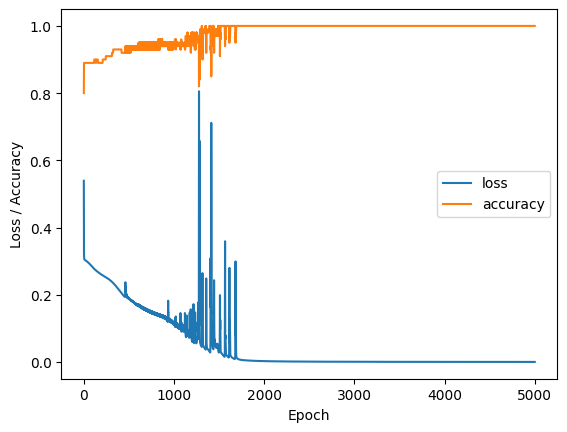

1984/1984 [==============================] - 4s 2ms/step


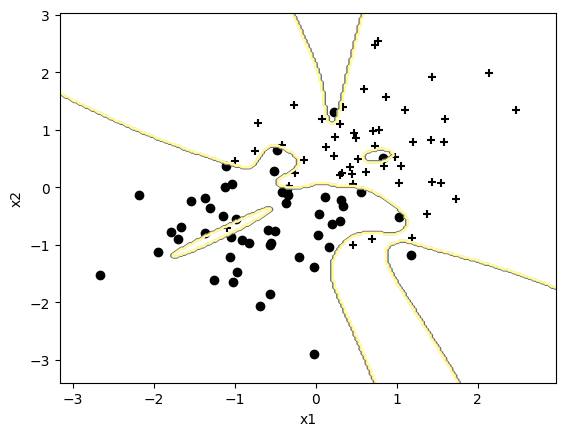

CPU times: user 26.2 s, sys: 2.57 s, total: 28.8 s
Wall time: 25.1 s


In [34]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 10
np.random.seed(seed) if seed else None
    
# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data 
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

#### 
# Define the network, cost function and training settings
INPUT3 = {'inp_dim': x_trn.shape[1],         
         'n_nod': [10, 10, 10],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.75,                    # learning rate
         'metric': 'accuracy'               # metric for evaluation
        } 
number_epochs = 5000
minibatch_size = 100
####

# Get the model
model_ex3 = mlp(**INPUT3)

# Print a summary of the model
model_ex3.summary()

# Train the model
estimator_ex3= model_ex3.fit(x_trn, d_trn,
                      epochs = number_epochs,                
                      batch_size = minibatch_size,                   
                      verbose = 0)

# Call the stats function to print out statistics for the training
stats_class(x_trn, d_trn, 'Training', model_ex3)

# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
for k in estimator_ex3.history.keys():
    plt.plot(estimator_ex3.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Show the decision boundary
decision_b(x_trn, d_trn, model_ex3)


# The report!

We have added intructions inside this report template. As you write your report, remove the instructions.

## Name

## Introduction
A few sentences about the overall theme of the exercise.

## Answers to questions
Provide enough information to clarify the meaning of your answers, so that they can be understood by someone who does not scroll up and read the entire instruction.

The questions are repeated here, for clarity of what is demanded. If it does not fit your style to quote them verbatim, change the format. 

#### Question 1, variations in pre-defined MLP
(a) Do you see the same loss vs epoch behavior each time your run? If not, why?


__Answer__:
One does not see the same loss vs epoch behavior for different runs. This stems from the weights of the network being initialized as a random sample drawn from a Gaussian distribution every time we create a new instance of the network class. The loss vs epoch curve will look different as the optimizer traverses a loss landscape from different initial points in each run. One might therefore end up at different points in the weight space for different runs. One might for example get stuck in a local minimum in one and not get stuck in the same one during a different run.  Hence we get a different loss vs epoch curve.



(b) Do you observe that training fails, i.e. do not reach low loss, during any of these five runs? 

__Answer__:
One could say that training fails in some instances. The smallest reported loss was $0.014 \approx 0$ which is the theoretical optimum of the MSE function since a quadratic function is always minorized by zero. In some instances, the loss training resulted in a network with around 0.4 loss. One could consider this a 'failure' however this loss might be good enough for the application of the network.

#### Question 2, vary learning rate
Present your average MSE results and discuss your findings.

__Answer__:
The learning rate greatly impacts the final MSE. If one uses too large of a learning rate the optimization fails to converge and the loss goes to infinity as shown in the upper-most row of the table below. If the learning rate is too small the descent is slow. A learning rate ~0.1 seems to perform the best.

| Learning Rate | MSE      | Remark                |
|---------------|----------|-----------------------|
| 0.5           | $\infty$ | Does not converge     |
| 0.2           | 0.0013   | Numerical instability |
| 0.1           | 0.0019   | -                     |
| 0.05          | 0.43     | Slow descent          |
| 0.02          | 0.48     | Slow descent          |

#### Question 3, vary (mini)batch size
Present and discuss your findings.

__Answer__:
Using a batch size of around 15 seems to be optimal for this learning rate. This is a bit surprising as one would guess that a cruder approximation of the gradient, i.e a smaller mini-batch size, would require more iterations to reach convergence. However, more randomness in the computation of the gradient increases the likelihood of the training algorithm getting stuck in non-optimal local minima. A smaller batch size increases the probability of escaping a less 'flat' minima in the parameter space and this might be the reason why it requires fewer iterations to reach a successful set of weights. 

| Batch Size | Successful (MSE < 0.01) | \#epochs to solution |
|------------|---------------------------|----------------------|
| 50         | True                      | 3000                 |
| 25         | True                      | 1400                 |
| 13         | True                      | 700                  |
| 10         | True                      | 700                  |
| 7          | False                     | -                    |

#### Question 4, select good hyper-parameters
Present your best combination of learning rate and batch size, and its result.

__Answer__:
Using the hyperparameters in the table below yields a loss of 0.0007 in 250 epochs. The solution converges since the learning rate is adequately small and does so fast enough since the learning rate is adequately large. The implicit regularization properties of mini-batch SGD might be the reason as to why it converges to a 'good' minima.

|Hyper Parameter | Value |
|------------------------|----------------|
| Mini-Batch Size        | 13             |
| Learning Rate          | 0.1            |

| Metric        | Value |
|------------------------|----------------|
| Final Loss             | 0.0007         |
| epochs to solution     | 250            |

#### Question 5, vary epochs
Compare the number of epochs needed to reach a good solution with that of Q4. If you cannot find a good solution in a reasonable number of epochs, you can "revert" the problem: optimize learning rate and batch size for Q5, and the see how those hyper-parameters perform on Q4.

__Answer__:
The more complicated regression problem does not converge as quickly as the simpler one. The table below displays the final loss using different number of epochs using the same learning rate and mini-batch size as in question 4. This set-up did not work very well for the more complex problem, probably due to a learning rate that was too large. Decreasing the learning rate and increasing the mini-batch size improved the results as shown below. Training for more than 4000 epochs seems to be redundant as indicated by the second elbow in the learning curve. One may note that the network is over-fitted from looking at the prediction vs actual curve, however this is fine in this application since we are not using the network for inference.

| Epochs | Mini-batch size | Learning Rate | Final Loss |
|---------------|--------------------------|------------------------|---------------------|
| 4000          | 13                       | 0.1                    | 0.0279169232        |
| 5000          | 13                       | 0.1                    | 0.5129871368        |
| 5000          | 26                       | 0.1                    | 0.0140060103        |
| 10 000        | 26                       | 0.1                    | 0.5054265857        |
| 10 000        | 26                       | 0.05                   | 0.0099055348        |
| 20 000        | 26                       | 0.05                   | 0.0548333600        |


#### Question 6, vary network size and other hyper-parameters
Present your set of good hyper-parameters and the result. 

Note: If you cannot solve this task in *reasonable* time, present your best attempt!

__Answer__:
The problem in question 6 further increases the level of complexity due to the decreasing amplitude of the sinusoidal signal. The table below shows the training results using different hyper-parameter configurations. Increasing the number of epochs and the learning rate proved to be effective as the network was slow to converge using the configuration in the last experiment of question 6. The last configuration yields in an adequate result.

| Epochs | Mini-batch size | Learning Rate | Final Loss |
|---------------|--------------------------|------------------------|---------------------|
| 20 000        | 26                       | 0.05                   | 0.080759684         |
| 30 000        | 26                       | 0.07                   | 0.0224116836        |
| 40 000        | 25                       | 0.08                   | 0.0085877609        |
| 50 000        | 13                       | 0.075                  | 0.0004980444        |


#### Question 7, optimize hyper-parameters for classification
Present your set of hyper-parameters that reach > 95% accuracy

__Answer__:
The classification task can be 'perfectly solved' by training a wide and deep network for a large number of epochs. This is congruent with the universal approximation theorem. The table below shows the accuracy and binary cross-entropy loss using different network configurations. As the last row indicates one may achieve perfect accuracy with a very deep and wide network. This, however, yields a strange decision boundary indicating that the network is over-fitted. This model would not generalize well to 'unseen' data. 

| Epochs | Mini-batch size | Learning Rate | Hidden layer sizes ([h_1,...,h_n]) | Accuracy | CEE |
|---------------|--------------------------|------------------------|-----------------------------------------------|-------------------|--------------|
| 500           | 100                      | 0.1                    | [1]                                           | 0.8900            | 0.3065       |
| 1000          | 100                      | 0.1                    | [5]                                           | 0.9000            | 0.3013       |
| 3000          | 100                      | 0.1                    | [5,5]                                         | 0.91              | 0.2385       |
| 5000          | 100                      | 0.1                    | [10,10]                                       | 0.91              | 0.2385       |
| 5000          | 100                      | 0.75                   | [5,5,5]                                       | 0.9800            | 0.0632       |
| 5000          | 100                      | 0.75                   | [10,10,10,10]                                 | 1                 | 0.0001       |


#### Question 8, change learning algorithm
Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them. Present changes you needed to make to improve the results of the Adam optimizer, if any.

__Answer__:
No significant improvement in terms of final MSE was produced from switching from SGD to Adam. However, the Adam optimizer converges more quickly as indicated in the table below. The same learning rate of 0.75 turned out to be appropriate for the Adam optimizer.

| Epochs | Mini-batch size | Learning Rate | Optimizer | Final Loss |
|---------------|--------------------------|------------------------|-----------|---------------------|
| 50 000        | 13                       | 0.075                  | SGD       | 0.0004980444        |
| 10 000        | 13                       | 0.05                   | Adam      | 0.0328110456        |
| 10 000        | 13                       | 0.075                  | Adam      | 0.0041296543        |


#### Bonus tasks (if you feel inspired)

## Summary
Connect the summary to your introduction, to provide a brief overview of your findings.

__Answer__:
This exercise shows the power of neural networks for basic classification and regression tasks and the importance of hyper-parameter tuning. The initial task provides a good intuition for how the random initialization of weights can result in different trained weights for the network and how training might 'fail' because of this if the training configuration is not set up for convergence to a 'good' minimum. The following two tasks shows the importance of choosing a good learning rate and batch size. Too large of a learning rate and the solution diverges, to small and it is too slow to converge. The learning curves also gives an intuition for the stochastic nature of mini-batch SGD. When the batch size is smaller the algorithm is 'more stochastic' as the gradient is approximated by fewer components of the actual gradient. This decreases computation time and increases the likelihood of the algorithm escaping a 'non-flat' minima in the parameter space. The learning curves give a visual representation of this as the descent is more erratic if a smaller batch size is used. Task 4, 5 and 6 provide a feel for how it is to work in practice as a machine learning engineer as it involves a lot of trial and error and waiting for the program to run. In task 7 one receives a visual representation of what a classifier does by looking at the decision boundary. It also gives a feel for the concept of an over-fitted network as one may achieve perfect accuracy with a network with lots of parameters. It also shows how this might not be desirable as the decision boundary becomes non-intuitive, indicating that the network does not generalize well. The final task shows how the Adam optimizer converges faster compared to standard SGD.
